/Users/pbs44/Library/Python/3.9/lib/python/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


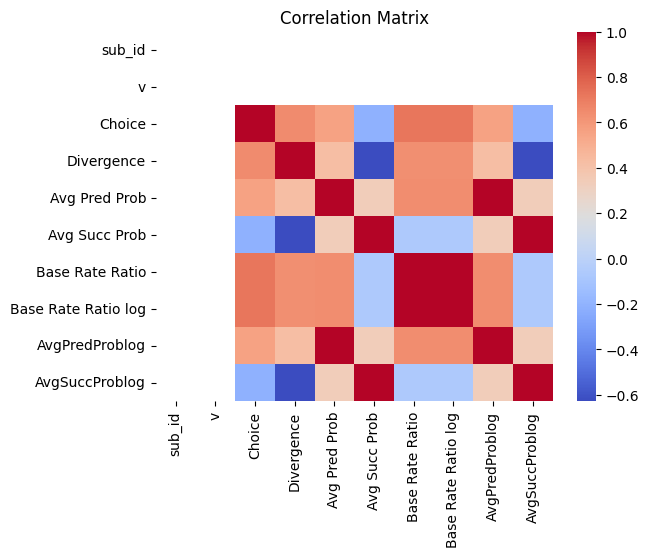

In [16]:
import arviz as az
import seaborn as sns
from scipy.stats import pearsonr as corrp
import pandas as pd
import matplotlib
import json 
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import seaborn as sns
from scipy.special import expit as logistic

df_new=pd.DataFrame()
df=pd.read_csv('actual_data_realworld_PR.csv')

# Define a dictionary to map variable names to their proper titles
var_title_map = {'q': 'Choice', 'e': 'Divergence', 'm': 'Avg Pred Prob', 'a': 'Avg Succ Prob', 'b': 'Base Rate Ratio'}

for sub in df.sub_id.unique():
    df_temp=pd.DataFrame()
    sub_name=[sub]*14
    df_temp['sub_id']=sub_name
    df_temp['v']=[float(int(df[df['sub_id']==sub].v.values))]*14
    df_temp['trial']=[*np.arange(1,15)]

    for var in var_title_map.keys():
        df1=df[df.sub_id==sub]
        filter_col = [col for col in df if col.startswith(var)]
        df1=df1[filter_col]
        df_temp[var_title_map[var]]=df1.values[0]
    df_new=pd.concat([df_new,df_temp])
    
#  Create log variables
df_new['Base Rate Ratio log'] = np.log(df_new['Base Rate Ratio'])
df_new['AvgPredProblog'] = np.log(df_new['Avg Pred Prob'])
df_new['AvgSuccProblog'] = np.log(df_new['Avg Succ Prob'])
df_new['Choice']=df_new['Choice'].astype('int')

Q=df_new['Choice']
sub_id=df_new['sub_id']
trials=df_new['trial']

df_new.to_csv('data_rw_bysub_fixed_full.csv')

df_new_groupby_e=df_new.groupby('Divergence').mean()
df_new_groupby_m=df_new.groupby('Avg Pred Prob').mean()
df_new_groupby_t=df_new.groupby('trial').mean()

df_new_groupby_t.to_csv('all_values.csv')
df_new_groupby_t_std=(df_new_groupby_t-df_new_groupby_t.mean())/df_new_groupby_t.std()

# Create a heat map of the correlations
corr_matrix = df_new_groupby_t.corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [17]:
import bambi as bmb
import arviz as az
print(df_new.head())
model2 = bmb.Model("Choice~Divergence+AvgPredProblog",family='bernoulli', data=df_new)
fitted2 = model2.fit(draws=1000)
summary_df2 = az.summary(fitted2,var_names=['Divergence'], hdi_prob=0.95)  # Exclude random effects conditioned on sub_id, consider 95% HDI
# Print the summary DataFrame
print(summary_df2)

Modeling the probability that Choice==1


   sub_id    v  trial  Choice  Divergence  Avg Pred Prob  Avg Succ Prob  \
0       1  1.0      1       1        7.06          0.420        0.00036   
1       1  1.0      2       1        6.70          0.450        0.00055   
2       1  1.0      3       1        5.51          0.420        0.00170   
3       1  1.0      4       1        5.22          0.067        0.00036   
4       1  1.0      5       1        4.74          0.450        0.00390   

   Base Rate Ratio  Base Rate Ratio log  AvgPredProblog  AvgSuccProblog  
0            11.49             2.441477       -0.867501       -7.929407  
1             6.11             1.809927       -0.798508       -7.505592  
2            11.49             2.441477       -0.867501       -6.377127  
3             7.78             2.051556       -2.703063       -7.929407  
4             6.11             1.809927       -0.798508       -5.546779  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Divergence, AvgPredProblog]


EOFError: 

# Generate sigmoidal regression line from R results

In [8]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import spearmanr as corr
from scipy.special import expit as logistic
from scipy.special import logit

# Extract posterior samples for the coefficients of x1 and x2
pred_values=[]
actual_values=[x for x in np.arange(-2,8,0.01)] #range of real values
trial_num=0
for divergence in np.arange(-2,8,0.01):
    pred_values.append(logistic(0.19*divergence+0.58))
    trial_num+=1
    

## Plot correlation between divergence and backward-learning consistent choice

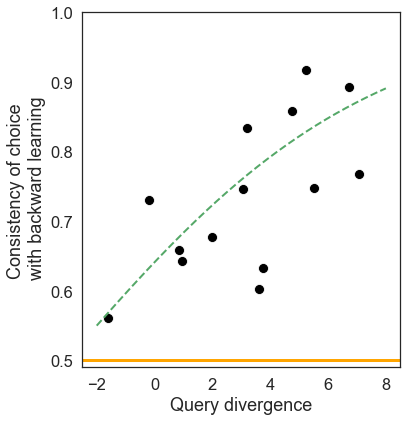

In [10]:
# Set style and font
sns.set(style='white', font='arial', font_scale=1.5, rc=None)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(6, 6.2))  # Adjust the figsize to make the height higher than the width
sns.scatterplot(x='Divergence', y='Choice', data=df_new_groupby_t, marker="o", color='black', s=100, ax=ax)

# Set labels and x-axis range
ax.set(xlabel='Query divergence', ylabel='Consistency of choice\n with backward learning')
ax.set_yticks(np.arange(0.5, 1.10, 0.1))
ax.set_ylim(0.49, 1)  # Ensure y-axis includes the value 1


# Add the green dashed line (replace "actual_values" and "pred_values" with your actual data)
ax.plot(actual_values, pred_values, color='g', linewidth=2, linestyle='dashed')

# Add the legend for the 0.5 marker
ax.axhline(0.5, color='orange',linewidth=3, linestyle='-', label="No evidence of backward learning")

# Save and show the plot
plt.tight_layout()
plt.savefig('scatterplot_diverginess_avgchoice_overlaidSigmoidRegressionLine.png', dpi=300)
plt.show()


# Confirmatory Hierarchical Bayesian Model
- models run in R in frequentist hierarchical LMM

In [36]:
import pymc as pm
import numpy as np
import pandas as pd
from scipy.special import expit

sub_idxs, subjs = pd.factorize(df_new.sub_id)
trial_idxs, trials = pd.factorize(df_new.trial)

coords = {
    "subj": subjs,
    "obs_id": np.arange(len(sub_idxs)),
    "trial": trials,
}

with pm.Model(coords=coords) as hierarchical_model2:
    sub_idxs = pm.Data("subject IDs", sub_idxs, dims="obs_id")
    trial_idxs = pm.Data("trials", trial_idxs, dims="obs_id")

    log_pred = pm.Data("log starting state probability data", df_new['Avg Pred Prob log'], dims="obs_id")
    diverginess = pm.Data("divergence data", df_new['Divergence'].values, dims="obs_id")

    # Hyperpriors for hierarchical effects of subject and trial
    sigma_trial = pm.HalfNormal("var_trial", 10)
    sigma_subject = pm.HalfNormal("var_subj", 10)

    # Fixed effects for diverginess and log_pred_prob and general intercept
    diverginess_effect = pm.Normal("divergence effect", 0, 1)
    log_pred_effect = pm.Normal("log starting state probability effect", 0, 1)
    intercept = pm.Normal("Intercept", 0, 1)

    # Subject-level effects of trial and subject
    trial_effect = pm.Normal("trial effect", mu=0, sigma=sigma_trial, dims="trial")
    subj_effect = pm.Normal("subject effect", mu=0, sigma=sigma_subject, dims="subj")

    # Reparameterize theta using a Beta distribution
    omega = pm.Deterministic(
        "mu",(intercept
        + (diverginess_effect * diverginess)
        + (log_pred_effect * log_pred)
        + subj_effect[sub_idxs]
        + trial_effect[trial_idxs]))

    theta = pm.Deterministic('logistic link', pm.math.invlogit(omega))

    # Data likelihood
    y = pm.Bernoulli("data", p=theta, observed=df_new.q.values, dims="obs_id")

gv=pm.model_to_graphviz(hierarchical_model2)
gv.format = 'png'
gv.render(filename='model_graph_bayesian_model_PRrealworld')
plt.show()
# with hierarchical_model2:
#     trace_logistic_model2 = pm.sample(draws=1000, target_accept=0.975, tune=500, cores=4)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [136]:
print(az.summary(trace_logistic_model2,var_names=['div','pred','Intercept','var_subj'],hdi_prob=0.95))

            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
div        0.157  0.071     0.023      0.307      0.002    0.002     880.0   
pred       0.082  0.098    -0.107      0.272      0.004    0.003     730.0   
Intercept  0.861  0.435     0.005      1.718      0.015    0.011     813.0   
var_subj   0.549  0.032     0.487      0.611      0.002    0.001     383.0   

           ess_tail  r_hat  
div           962.0   1.00  
pred         1070.0   1.01  
Intercept    1247.0   1.01  
var_subj      989.0   1.00  


In [137]:
import pymc as pm
import numpy as np
import pandas as pd
from scipy.special import expit

sub_idxs, subjs = pd.factorize(df_new.sub_id)
trial_idxs, trials = pd.factorize(df_new.trial)

coords = {
    "subj": subjs,
    "obs_id": np.arange(len(sub_idxs)),
    "trial": trials,
}

with pm.Model(coords=coords) as hierarchical_model3:
    sub_idxs = pm.Data("sub_idxs", sub_idxs, dims="obs_id")
    trial_idxs = pm.Data("trial_idxs", trial_idxs, dims="obs_id")

    log_succ = pm.Data("log_pred_data", df_new['Avg Succ Prob log'], dims="obs_id")
    diverginess = pm.Data("div_data", df_new['Divergence'], dims="obs_id")

    # Hyperpriors for hierarchical effects of subject and trial
    sigma_trial = pm.HalfNormal("var_trial", 10)
    sigma_subject = pm.HalfNormal("var_subj", 10)

    # Fixed effects for diverginess and log_pred_prob and general intercept
    diverginess_effect = pm.Normal("div", 0, 1)
    log_succ_effect = pm.Normal("succ", 0, 1)
    intercept = pm.Normal("Intercept", 0, 1)

    # Subject-level effects of trial and subject
    trial_effect = pm.Normal("trial_effect", mu=0, sigma=sigma_trial, dims="trial")
    subj_effect = pm.Normal("subj_effect", mu=0, sigma=sigma_subject, dims="subj")

    # Reparameterize theta using a Beta distribution
    omega = pm.Deterministic(
        "mu",(intercept
        + (diverginess_effect * diverginess)
        + (log_succ_effect * log_succ)
        + subj_effect[sub_idxs]
        + trial_effect[trial_idxs]))

    theta = pm.Deterministic('logistic link', pm.math.invlogit(omega))

    # Data likelihood
    y = pm.Bernoulli("data", p=theta, observed=df_new['Choice'].values, dims="obs_id")


with hierarchical_model3:
    trace_logistic_model3 = pm.sample(draws=1000, target_accept=0.975, tune=500, cores=4)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pymc/data.py:406: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  """
Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var_trial, var_subj, div, succ, Intercept, trial_effect, subj_effect]
INFO:pymc:NUTS: [var_trial, var_subj, div, succ, Intercept, trial_effect, subj_effect]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1124 seconds.
INFO:pymc:Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1124 seconds.


In [138]:
print(az.summary(trace_logistic_model3,var_names=['div','succ','Intercept','var_subj'],hdi_prob=0.95))

            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
div        0.234  0.096     0.039      0.413      0.003    0.002    1111.0   
succ       0.077  0.100    -0.119      0.260      0.003    0.002    1079.0   
Intercept  0.855  0.438    -0.017      1.680      0.012    0.009    1260.0   
var_subj   0.543  0.032     0.476      0.602      0.001    0.001     496.0   

           ess_tail  r_hat  
div          1411.0    1.0  
succ         1274.0    1.0  
Intercept    1529.0    1.0  
var_subj     1121.0    1.0  
